## Import libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)

## Defining the DCNN model architecture

In [13]:
class DCNN(nn.Module):

    def __init__(self):
        super(DCNN, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


dcnn = DCNN()
print(dcnn)

DCNN(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define the model training routine

In [14]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

## Define the model testing routine

In [15]:
def test(net, testloader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in testloader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('DCNN accuracy on 10000 images from test dataset: %d %%' % (
        100 * success / counter))

## Load and transform the dataset

In [16]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)


test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False, num_workers=2)


# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualise a sample of the dataset

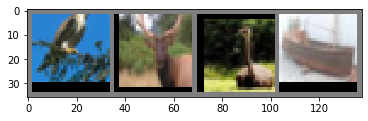

    bird  ||  deer  ||  bird  ||  ship


In [17]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
dataiter = iter(trainloader)
images, labels = dataiter.next()

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

## Start the model training loop

In [23]:
# define optimizer
optim = torch.optim.Adam(dcnn.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):  
    train(dcnn, trainloader, optim, epoch)
    print()
    test(dcnn, testloader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 8.226
[Epoch number : 1, Mini-batches:  2000] loss: 7.926
[Epoch number : 1, Mini-batches:  3000] loss: 7.780
[Epoch number : 1, Mini-batches:  4000] loss: 7.630
[Epoch number : 1, Mini-batches:  5000] loss: 7.490
[Epoch number : 1, Mini-batches:  6000] loss: 7.403

DCNN accuracy on 10000 images from test dataset: 50 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.269
[Epoch number : 2, Mini-batches:  2000] loss: 7.180
[Epoch number : 2, Mini-batches:  3000] loss: 7.040
[Epoch number : 2, Mini-batches:  4000] loss: 7.060
[Epoch number : 2, Mini-batches:  5000] loss: 6.977
[Epoch number : 2, Mini-batches:  6000] loss: 6.937

DCNN accuracy on 10000 images from test dataset: 52 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.891
[Epoch number : 3, Mini-batches:  2000] loss: 6.740
[Epoch number : 3, Mini-batches:  3000] loss: 6.707
[Epoch number : 3, Mini-batches:  4000] loss: 6.753
[Epoch number : 3, Mini-batches:  5000] loss: 6.641
[Epo

[Epoch number : 23, Mini-batches:  2000] loss: 5.184
[Epoch number : 23, Mini-batches:  3000] loss: 5.138
[Epoch number : 23, Mini-batches:  4000] loss: 5.224
[Epoch number : 23, Mini-batches:  5000] loss: 5.212
[Epoch number : 23, Mini-batches:  6000] loss: 5.181

DCNN accuracy on 10000 images from test dataset: 66 %

[Epoch number : 24, Mini-batches:  1000] loss: 5.208
[Epoch number : 24, Mini-batches:  2000] loss: 5.171
[Epoch number : 24, Mini-batches:  3000] loss: 5.084
[Epoch number : 24, Mini-batches:  4000] loss: 5.205
[Epoch number : 24, Mini-batches:  5000] loss: 5.195
[Epoch number : 24, Mini-batches:  6000] loss: 5.178

DCNN accuracy on 10000 images from test dataset: 66 %

[Epoch number : 25, Mini-batches:  1000] loss: 5.063
[Epoch number : 25, Mini-batches:  2000] loss: 5.175
[Epoch number : 25, Mini-batches:  3000] loss: 5.148
[Epoch number : 25, Mini-batches:  4000] loss: 5.076
[Epoch number : 25, Mini-batches:  5000] loss: 5.051
[Epoch number : 25, Mini-batches:  6000]

[Epoch number : 45, Mini-batches:  2000] loss: 5.026
[Epoch number : 45, Mini-batches:  3000] loss: 4.970
[Epoch number : 45, Mini-batches:  4000] loss: 5.004
[Epoch number : 45, Mini-batches:  5000] loss: 5.074
[Epoch number : 45, Mini-batches:  6000] loss: 4.908

DCNN accuracy on 10000 images from test dataset: 67 %

[Epoch number : 46, Mini-batches:  1000] loss: 4.825
[Epoch number : 46, Mini-batches:  2000] loss: 5.092
[Epoch number : 46, Mini-batches:  3000] loss: 4.979
[Epoch number : 46, Mini-batches:  4000] loss: 4.878
[Epoch number : 46, Mini-batches:  5000] loss: 5.026
[Epoch number : 46, Mini-batches:  6000] loss: 4.980

DCNN accuracy on 10000 images from test dataset: 68 %

[Epoch number : 47, Mini-batches:  1000] loss: 4.819
[Epoch number : 47, Mini-batches:  2000] loss: 4.968
[Epoch number : 47, Mini-batches:  3000] loss: 5.066
[Epoch number : 47, Mini-batches:  4000] loss: 4.973
[Epoch number : 47, Mini-batches:  5000] loss: 4.784
[Epoch number : 47, Mini-batches:  6000]

## Save trained model

In [25]:
model_path = './cifar_model.pth'
torch.save(dcnn.state_dict(), model_path)

## Load saved trained model and make predictions

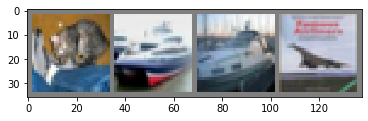

Label:         cat  ship  ship plane
Prediction:    cat   car  ship plane


In [36]:
# load test dataset images
d_iter = iter(testloader)
im, ground_truth = d_iter.next()

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
dcnn_cached = DCNN()
dcnn_cached.load_state_dict(torch.load(model_path))

# model inference
op = dcnn_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

## Evaluate overall model performance on test set

In [27]:
success = 0
counter = 0
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = dcnn_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from test dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from test dataset: 66 %


## Evaluate per-class model performance on the test set

In [28]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        im, ground_truth = data
        op = dcnn_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 70 %
Model accuracy for class   car : 83 %
Model accuracy for class  bird : 35 %
Model accuracy for class   cat : 58 %
Model accuracy for class  deer : 76 %
Model accuracy for class   dog : 50 %
Model accuracy for class  frog : 77 %
Model accuracy for class horse : 62 %
Model accuracy for class  ship : 74 %
Model accuracy for class truck : 76 %
